Now that we have cleaned our data and explored it, the next step is to determine features we think would be useful in explaining the target variable. This step is called **feature engineering**. In this checkpoint, we introduce how we should approach feature engineering and what kind of techniques we can use.

In this step of the EDA process, we need to transform our variables into **features**. We call the variables *features* if we think they are well-suited to work within our model to explain the target variable. Feature engineering is the process of selecting or modifying the existing variables and creating new ones that will be used in our models. Feature engineering is a [broad and complex topic](http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/), and an opportunity to get creative with your data. Throughout this checkpoint, we’ll talk about how to pare down a set of features into the best ones for our problem. The figure below shows where we are in the general EDA process:

![feature_engineering.png](feature_engineering.png)

Just as we emphasized in the previous checkpoints, EDA is an iterative process and when we encounter a problem with our data in the feature engineering phase, we need to eliminate the problem first. By the same token, when we modify a variable or create a new one, we need to apply data exploration techniques to understand whether this new variable is useful or not. Like other checkpoints, we give examples to illustrate the techniques, but keep in mind here that feature engineering is a wide domain. When you are working with your data, don’t limit yourself to what you see–try anything you think will highlight a particular feature within your dataset.

We'll analyze feature engineering in 3 steps:

1. Transforming the existing variables.
2. Creating new variables.
3. Selecting the features.

We will cover the 1st and 2nd steps in this checkpoint and then cover the 3rd step to the next one.

# Transforming the existing variables

Transforming the existing variables is a very common need for numerous reasons. Among them, we limit our attention to the following:

1. Machine learning models can only work with numeric variables. So, categorical variables that have text values need to be converted to numeric values.
2. Some machine learning models assume the target variable to be normally distributed. In order to use these models, we may need to transform our target to be normally distributed.
3. Some machine learning models are very sensitive to the relative magnitude of values. So, we may need to limit the values of the variables to some fixed range. Usually, we do this by normalizing our variables.
4. To help our intuition and our understanding of the data, we may want to transform variables to a different unit of measurement. 

Let's work through examples of each case. 

## Working with categorical variables

Since most models require that all data be numeric, we need to convert our string based categorical data to use it. One method for this purpose is called **one hot encoding**. In one hot encoding, to get the information from a categorical variable with X levels, we create X-1 numeric features, each of which is coded 1 or 0. The resulting variables that take 0 or 1 for each category are known as **dummy** or **indicator** variables. To apply one hot encoding to a categorical variable, we can use the Pandas `.get_dummies()` function.

Consider the YouTube dataset. The variable *Grade* is categorical, taking the values `A++`, `A+`, `A`, `A-`, `B+`. While the *Grade* variable has 5 levels, only 4 features are needed to represent all of the information. Why 4? The reason being, if we know the values for `A++`, `A+`, `A`, and `A-` are 0, then we also know that the value for `B+` must be 1. This level without a feature is called the _reference_ value.

Let's load our YouTube dataset and create dummy variables for the *Grade* variable:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'youtube'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

youtube_df = pd.read_sql_query('select * from youtube',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

# we're dealing with the missing values

youtube_df["Video Uploads"] = youtube_df["Video Uploads"].apply(str.strip).replace("--", np.nan)
youtube_df["Video Uploads"] = pd.to_numeric(youtube_df["Video Uploads"], downcast="float")

youtube_df["Subscribers"] = youtube_df["Subscribers"].apply(str.strip).replace("--", np.nan)
youtube_df["Subscribers"] = pd.to_numeric(youtube_df["Subscribers"], downcast="float")

youtube_df.Grade = youtube_df.Grade.apply(str.strip).replace("", np.nan)


youtube_df["Video Uploads"].fillna(youtube_df["Video Uploads"].mean(), inplace=True)
youtube_df["Subscribers"].fillna(youtube_df["Subscribers"].mean(), inplace=True)


# We apply one-way winsorization to the highest end
# of the value distribution. As we have a lot of extreme
# values, we set the values of the outliers to the 
# value of the 90th percentile. 
youtube_df["winsorized_uploads"] = winsorized_views = winsorize(youtube_df["Video Uploads"], (0, 0.10))
youtube_df["winsorized_subscribers"] = winsorized_views = winsorize(youtube_df["Subscribers"], (0, 0.10))
youtube_df["winsorized_views"] = winsorized_views = winsorize(youtube_df["Video views"], (0, 0.10))

for i in range(0, len(youtube_df.Grade)):
    if pd.isnull(youtube_df.Grade[i]):
        youtube_df.Grade[i] = youtube_df.Grade[i-1]
        
# one-hot encoding the Grade variable: 
pd.get_dummies(youtube_df["Grade"])

,A,A+,A++,A-,B+
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
...,...,...,...,...,...
4995,0,0,0,0,1
4996,0,0,0,0,1
4997,0,0,0,0,1
4998,0,0,0,0,1


Notice that the `.get_dummies()` function returned 1 dummy variable for each category by naming the dummies in reference to the values of the *Grade* variable. However, we ought to exclude 1 of the variables from dummy-coding when we include them in a model for the reasons explained above. 

If you fear that you'll forget this point, you can set the `drop_first` parameter of `.get_dummies()` to `True`. This will exclude the 1st category from dummy-coding.

Also, keep in mind, just calling `pd.get_dummies(youtube_df["Grade"])` won't store the dummies in the data frame; you can append them to the data frame by using `pd.concat()`. The `axis = 1` parameter will concatenate the 2 DataFrames along the column: 

In [2]:
# append dummies to YouTube dataframe
youtube_df = pd.concat([youtube_df, pd.get_dummies(youtube_df["Grade"])], axis=1)
youtube_df

,Rank,Grade,Channel name,Video Uploads,Subscribers,Video views,winsorized_uploads,winsorized_subscribers,winsorized_views,A,A+,A++,A-,B+
0,1st,A++,Zee TV,82757.0,18752952.0,20869786591,5653.0,5895361.0,2468241402,0,0,1,0,0
1,2nd,A++,T-Series,12661.0,61196304.0,47548839843,5653.0,5895361.0,2468241402,0,0,1,0,0
2,3rd,A++,Cocomelon - Nursery Rhymes,373.0,19238252.0,9793305082,373.0,5895361.0,2468241402,0,0,1,0,0
3,4th,A++,SET India,27323.0,31180560.0,22675948293,5653.0,5895361.0,2468241402,0,0,1,0,0
4,5th,A++,WWE,36756.0,32852346.0,26273668433,5653.0,5895361.0,2468241402,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"4,996th",B+,Uras Benlioğlu,706.0,2072942.0,441202795,706.0,2072942.0,441202795,0,0,0,0,1
4996,"4,997th",B+,HI-TECH MUSIC LTD,797.0,1055091.0,377331722,797.0,1055091.0,377331722,0,0,0,0,1
4997,"4,998th",B+,Mastersaint,110.0,3265735.0,311758426,110.0,3265735.0,311758426,0,0,0,0,1
4998,"4,999th",B+,Bruce McIntosh,3475.0,32990.0,14563764,3475.0,32990.0,14563764,0,0,0,0,1


## Dealing with non normality

As we have mentioned before, many machine learning models assume the target variable to be normally distributed. If normality is an assumption, then non normal variables can sometimes be transformed into normally distributed features using transformations such as taking the **square root**, the **inverse**, or the **log** of the variable; or by applying the **Box-Cox transformation**. 

Remember that we touched upon these techniques in our earlier checkpoint on data cleaning and outliers. Applying transformations, such as a log, not only helps with outliers, it also effects the variable's distribution.

In the previous checkpoint on univariate analysis, we used histograms to visualize continuous variables in the YouTube dataset:

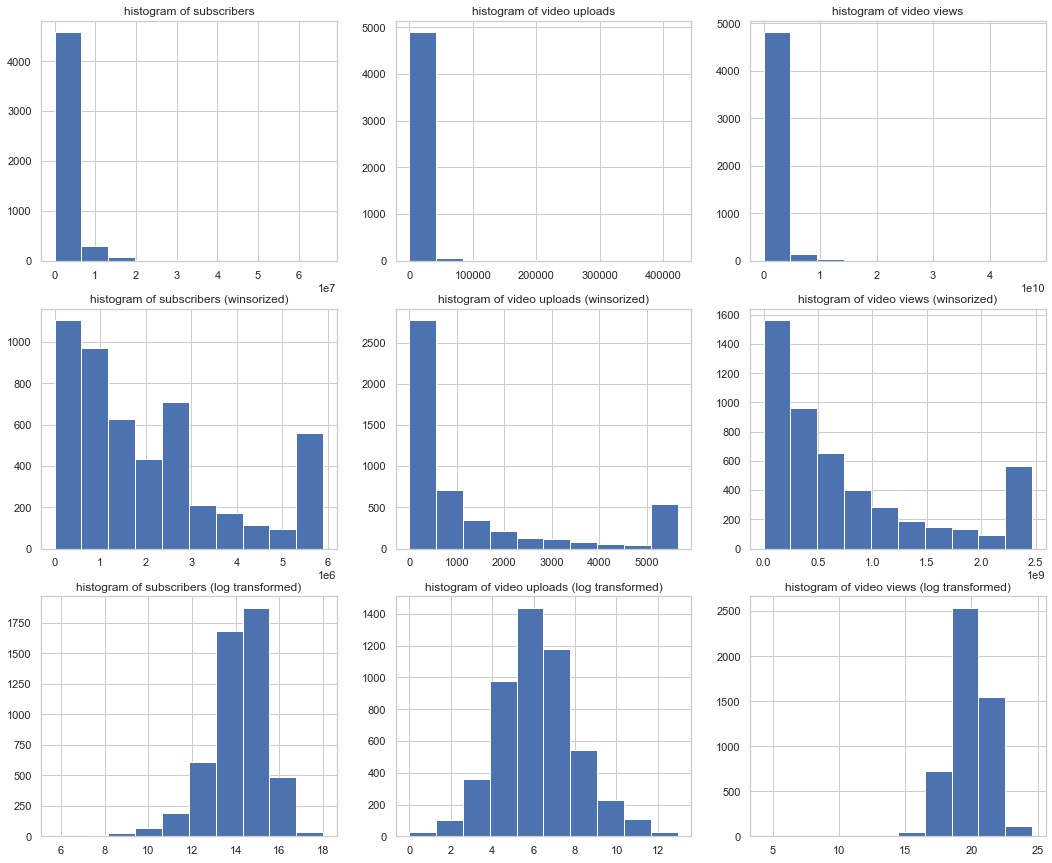

In [3]:
plt.figure(figsize=(18,15))

# histograms of the original data
plt.subplot(3, 3, 1)
plt.hist(youtube_df["Subscribers"])
plt.title("histogram of subscribers")

plt.subplot(3, 3, 2)
plt.hist(youtube_df["Video Uploads"])
plt.title("histogram of video uploads")

plt.subplot(3, 3, 3)
plt.hist(youtube_df["Video views"])
plt.title("histogram of video views")

# histograms of the winsorized data
plt.subplot(3, 3, 4)
plt.hist(youtube_df["winsorized_subscribers"])
plt.title("histogram of subscribers (winsorized)")

plt.subplot(3, 3, 5)
plt.hist(youtube_df["winsorized_uploads"])
plt.title("histogram of video uploads (winsorized)")

plt.subplot(3, 3, 6)
plt.hist(youtube_df["winsorized_views"])
plt.title("histogram of video views (winsorized)")

# histograms of the log transformed data
plt.subplot(3, 3, 7)
plt.hist(np.log(youtube_df["Subscribers"]))
plt.title("histogram of subscribers (log transformed)")

plt.subplot(3, 3, 8)
plt.hist(np.log(youtube_df["Video Uploads"]))
plt.title("histogram of video uploads (log transformed)")

plt.subplot(3, 3, 9)
plt.hist(np.log(youtube_df["Video views"]))
plt.title("histogram of video views (log transformed)")


plt.show()

It appears that taking the logs of the 3 variables above transformed the distributions of the variables so that they more closely resemble the normal distribution. However, they are not *exactly* normally distributed. 

In our example, we can statistically verify the distributions of the log transformed variables still don't follow the normal distribution by using the **Jarque-Bera** and **Normal** tests from `scipy`:

In [4]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(np.log(youtube_df["Subscribers"]))
norm_stats = normaltest(np.log(youtube_df["Subscribers"]))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.log(youtube_df["Video Uploads"]))
norm_stats = normaltest(np.log(youtube_df["Video Uploads"]))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.log(youtube_df["Video views"]))
norm_stats = normaltest(np.log(youtube_df["Video views"]))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3650.185300455545 and p value is 0.0
Normality test statistics is 1168.7793574548339 and p value is 1.5950975481327862e-254
Jarque-Bera test statistics is 83.01327886301631 and p value is 0.0
Normality test statistics is 71.51141329001395 and p value is 2.961378421556997e-16
Jarque-Bera test statistics is 7862.3171340522895 and p value is 0.0
Normality test statistics is 1180.823167194929 and p value is 3.8681846024387925e-257


The p-values are 0 which indicates that the distribution of the log transformed variables is statistically different from the normal distribution. However, these transformations might still be useful. In general, working with distributions that "look" normal (with 2 tails on the left and right and a clustering of values around the mean) is easier than working with 1 tailed distributions. Even still, some models only require multivariate normality which can be achieved more easily using these kinds of distributions. Hence, if we see that the distribution of a variable more closely resembles the normal distribution after a transformation, it could still be helpful even if it's not *exactly* normal.

Another common method to make variables normally distributed is the **Box-Cox transformation**. Applying this transformation is pretty easy using SciPy's `boxcox()` function from the `stats` module:

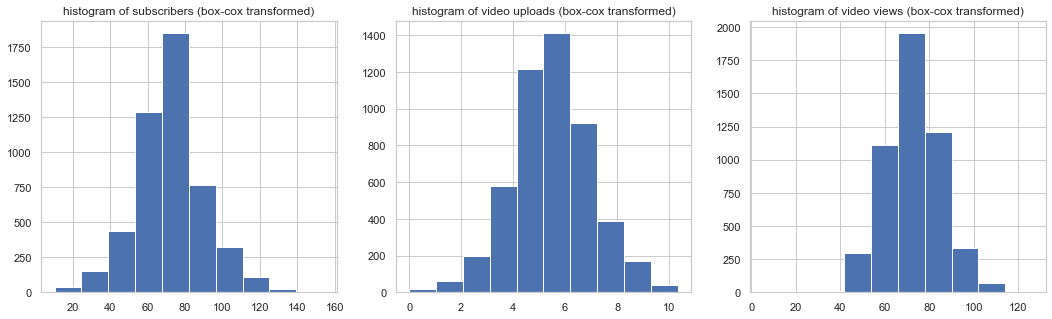

In [5]:
from scipy.stats import boxcox

video_uploads_boxcox,_ = boxcox(youtube_df["Video Uploads"])
subscribers_boxcox,_ = boxcox(youtube_df["Subscribers"])
video_views_boxcox,_ = boxcox(youtube_df["Video views"])

plt.figure(figsize=(18,5))

# histograms of the box-cox transformed data
plt.subplot(1, 3, 1)
plt.hist(subscribers_boxcox)
plt.title("histogram of subscribers (box-cox transformed)")

plt.subplot(1, 3, 2)
plt.hist(video_uploads_boxcox)
plt.title("histogram of video uploads (box-cox transformed)")

plt.subplot(1, 3, 3)
plt.hist(video_views_boxcox)
plt.title("histogram of video views (box-cox transformed)")

plt.show()

The histograms above resemble the normal distribution quite well, although they are still not quite normally distributed. We can confirm this using the Jargue-Bera and Normal tests:

In [6]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(subscribers_boxcox)
norm_stats = normaltest(subscribers_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(video_uploads_boxcox)
norm_stats = normaltest(video_uploads_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(video_views_boxcox)
norm_stats = normaltest(video_views_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 112.2691040776772 and p value is 0.0
Normality test statistics is 64.32778131642941 and p value is 1.0749784809968669e-14
Jarque-Bera test statistics is 32.00644734618816 and p value is 1.1217298223620276e-07
Normality test statistics is 23.237402615147847 and p value is 8.996262833613851e-06
Jarque-Bera test statistics is 93.4064021228951 and p value is 0.0
Normality test statistics is 55.77146119242227 and p value is 7.751416591883903e-13


**Note that Box-Cox, log, and square root transformations only work when all datapoints are positive**.

## Normalization and standardization

Some statistical techniques, such as principal components analysis—which we'll see in the following checkpoint—and machine learning models assume that all features have values in the same range (e.g., a min of 0 and a max of 1) or they exhibit normal statistical properties. For some techniques, features that vary in range can result in incorrect estimates and results. To be able to apply these techniques and methods, we need to rescale our variables to fit a limited range, or standardize our variables to exhibit some regular statistical patterns. 

In this checkpoint, we discuss 2 concepts of rescaling: **normalization** and **standardization**.

1. Normalization is the rescaling of a variable into the [0,1] range (including 0 and 1). For this purpose, we'll use SKLearn's `.normalize()` method from the `preprocessing` module.
2. Standardization is the rescaling of a variable so its mean becomes 0 and its standard deviation becomes 1. Notice in the standardization we don't apply a maximum value for the variable. To apply standardization, we'll use SKLearn's `.scale()` method from the `preprocessing` module.

If this is your initial time using `scikit-learn`, you'll want to call `pip install sklearn` from  your terminal to install the package.

Let's see how we can normalize the winsorized versions of the continuous variables in the YouTube dataset:

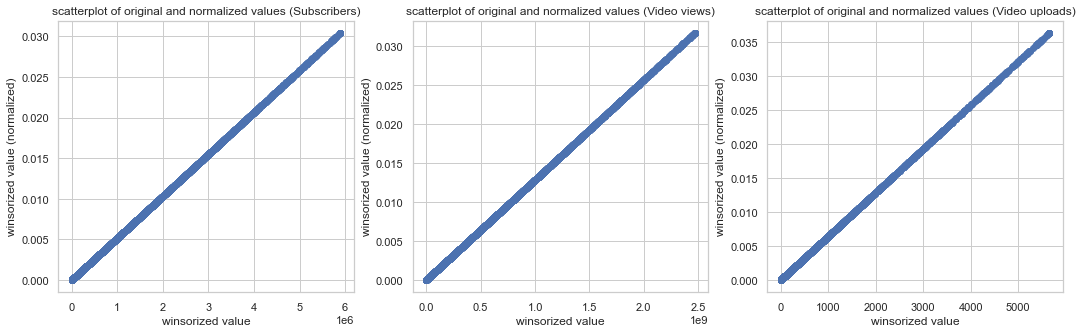

In [7]:
from sklearn.preprocessing import normalize

# normalize the winsorized variables
youtube_df["norm_winsorized_subscribers"] = normalize(np.array(youtube_df["winsorized_subscribers"]).reshape(1,-1)).reshape(-1,1)
youtube_df["norm_winsorized_views"] = normalize(np.array(youtube_df["winsorized_views"]).reshape(1,-1)).reshape(-1,1)
youtube_df["norm_winsorized_uploads"] = normalize(np.array(youtube_df["winsorized_uploads"]).reshape(1,-1)).reshape(-1,1)

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
# draw the scatter plot using seaborn.
plt.scatter(youtube_df["winsorized_subscribers"], youtube_df["norm_winsorized_subscribers"])
plt.title("scatterplot of original and normalized values (Subscribers)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (normalized)")

plt.subplot(1,3,2)
# draw the scatter plot using seaborn.
plt.scatter(youtube_df["winsorized_views"], youtube_df["norm_winsorized_views"])
plt.title("scatterplot of original and normalized values (Video views)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (normalized)")

plt.subplot(1,3,3)
# draw the scatter plot using seaborn.
plt.scatter(youtube_df["winsorized_uploads"], youtube_df["norm_winsorized_uploads"])
plt.title("scatterplot of original and normalized values (Video uploads)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (normalized)")

plt.show()

This time, let's standardize the variables: 

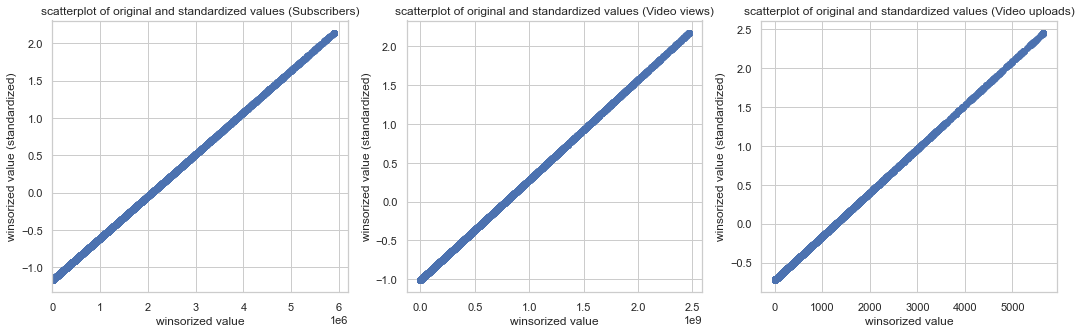

In [8]:
from sklearn.preprocessing import scale

youtube_df["scaled_winsorized_subscribers"] = scale(youtube_df["winsorized_subscribers"])
youtube_df["scaled_winsorized_views"] = scale(youtube_df["winsorized_views"])
youtube_df["scaled_winsorized_uploads"] = scale(youtube_df["winsorized_uploads"])

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
# draw the scatter plot using seaborn.
plt.scatter(youtube_df["winsorized_subscribers"], youtube_df["scaled_winsorized_subscribers"])
plt.title("scatterplot of original and standardized values (Subscribers)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (standardized)")
plt.xlim(0.00000001)

plt.subplot(1,3,2)
# draw the scatter plot using seaborn.
plt.scatter(youtube_df["winsorized_views"], youtube_df["scaled_winsorized_views"])
plt.title("scatterplot of original and standardized values (Video views)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (standardized)")

plt.subplot(1,3,3)
# draw the scatter plot using seaborn.
plt.scatter(youtube_df["winsorized_uploads"], youtube_df["scaled_winsorized_uploads"])
plt.title("scatterplot of original and standardized values (Video uploads)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (standardized)")

plt.show()

## Making variables easier to understand

Transforming variables for ease of understanding and interpretation is a common practice. For example, if the research question is formulated in terms of centimeters but a variable is measured in feet, we can either convert the variable to centimeters or, even better, we can create a new variable in terms of a neutral unit of measurement, such as standard deviations.

Transforming variables is also common in time series data. In finance, we usually care about the change in a stock price over the course of time rather than its level. Similarly, we usually measure the change in the economic activity from quarter to quarter rather than the level of the activity in each quarter. In those kinds of cases, if we have variables that only measure the levels, we may want to transform them to changes.

We can also recode a variable to make a feature that matches the terminology of the research question. For example, if our research question involves measuring "sadness," it will be easier to interpret our results if any variables put in terms of "happiness" are reverse coded so that the scores are in the same "direction" as the research question.


# Creating new variables

Sometimes, we may want to define new features we believe will be useful in explaining our target variable. If that statement sounds general, it is: because the only limit here is your own creativity. Let's start with an example:

Say that we have a variable called *name* in our dataset. This variable has values like `Mr. Adam Smith`, `Sir Anthony Hopkins`, `Queen Elizabeth`, `Papa James Hetfield`, etc. This is text data, and, as such, it's hard to use in a model. However, with the help of our imagination we can derive a useful feature from it. By deriving titles like "Mr", "Sir", "Queen", or "Papa" from the names, we can determine the gender of the person and create a new feature called *gender*. You can also try to imagine what you can do with a variable that holds the full addresses of the people.

Since this topic is very broad, we just mention here a few common use cases that you may find useful when working with continuous variables:

1. **Combining 2 or more highly correlated variables**: Many models assume that features are correlated with the outcome but uncorrelated with each other. Two highly correlated variables can be averaged to create a feature, or one can be dropped. Three or more highly correlated variables can also be combined using a statistical method called **Principal Components Analysis** (PCA) that reduces the correlated set of variables into a smaller set of uncorrelated features. We’ll do an in depth introduction to PCA in the next checkpoint.

2. **Interactions of variables**: If you suspect the relationship between the outcome and a feature depends on the value of a 2nd feature, you may want to create a feature that represents the interaction between them. Say, for example, watching more TV only makes people sad if they do it alone. People who live with a partner are probably less likely to watch TV alone. To represent the concept that people who live with a romantic partner don't get sad watching TV but people who don't live with a romantic partner do get sad, we can multiply our 'partner' indicator by the 'sadness' feature to create the interaction.

3. **Creating linear relationships**: Many models assume that the relationship between a feature and an outcome is linear. However, at times you want to include a variable that has a nonlinear component to its relationship with the outcome. To capture nonlinearity while satisfying the model's assumptions, it can be helpful to create quadratic or higher level features by squaring, cubing, or otherwise multiplying a variable by itself. 